In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install imutils

In [3]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours

In [4]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
!unzip -qo data.zip

--2024-05-20 05:56:47--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.96, 52.219.62.72, 16.12.40.103, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28437489 (27M) [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip            100%[===================>]  27.12M  8.23MB/s    in 3.3s    

2024-05-20 05:56:51 (8.23 MB/s) - ‘data.zip’ saved [28437489/28437489]



In [5]:
x = []
y = []
datadir = 'data/dataset'
for folder in os.listdir(datadir):
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)

print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

7600
7600
labels : ['7', '8', '0', 'sub', '1', '2', '3', 'div', 'mul', '6', '5', '9', '4', 'add']


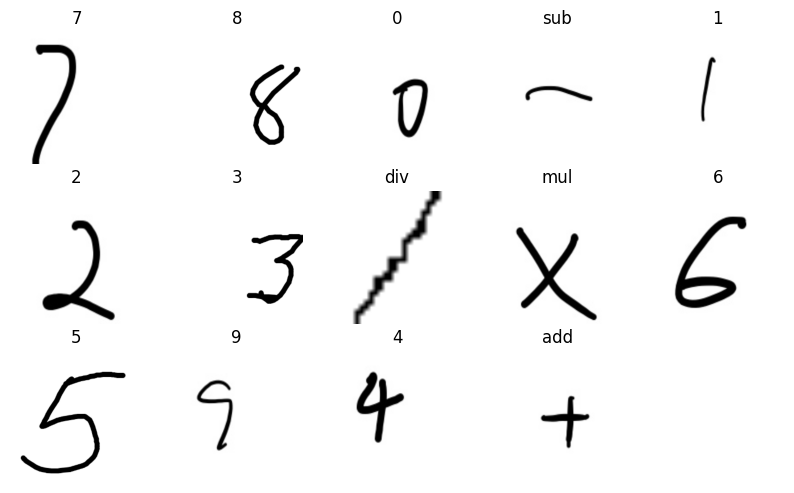

In [6]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

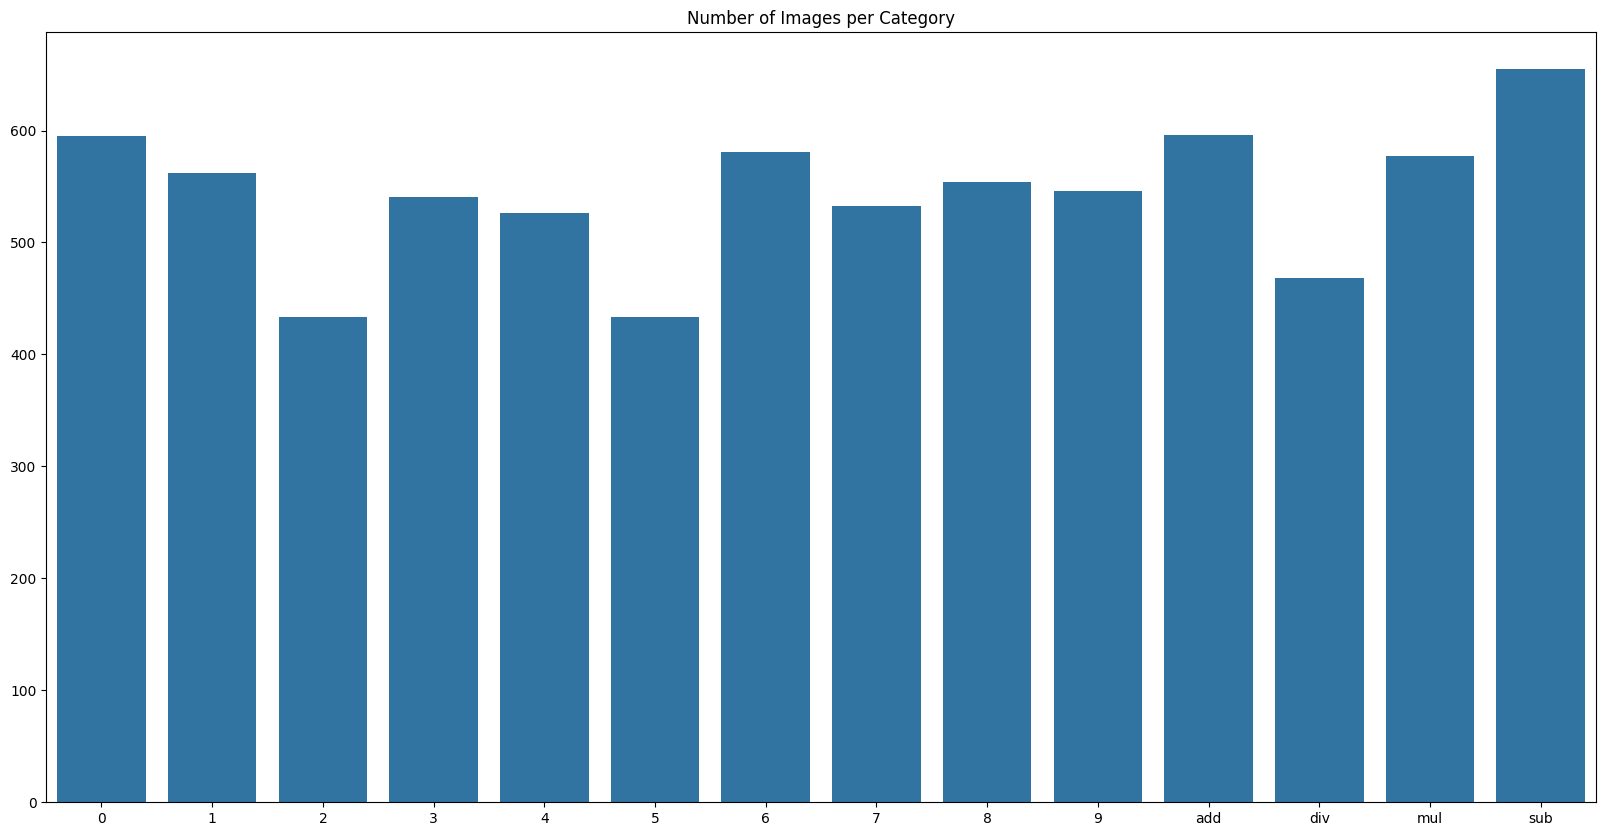

In [8]:
unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(x=unique, y=count).set_title('Number of Images per Category')
plt.show()

In [9]:
X = []
for i in range(len(x)):
#     print(i)
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

7600


In [10]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))

7600


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

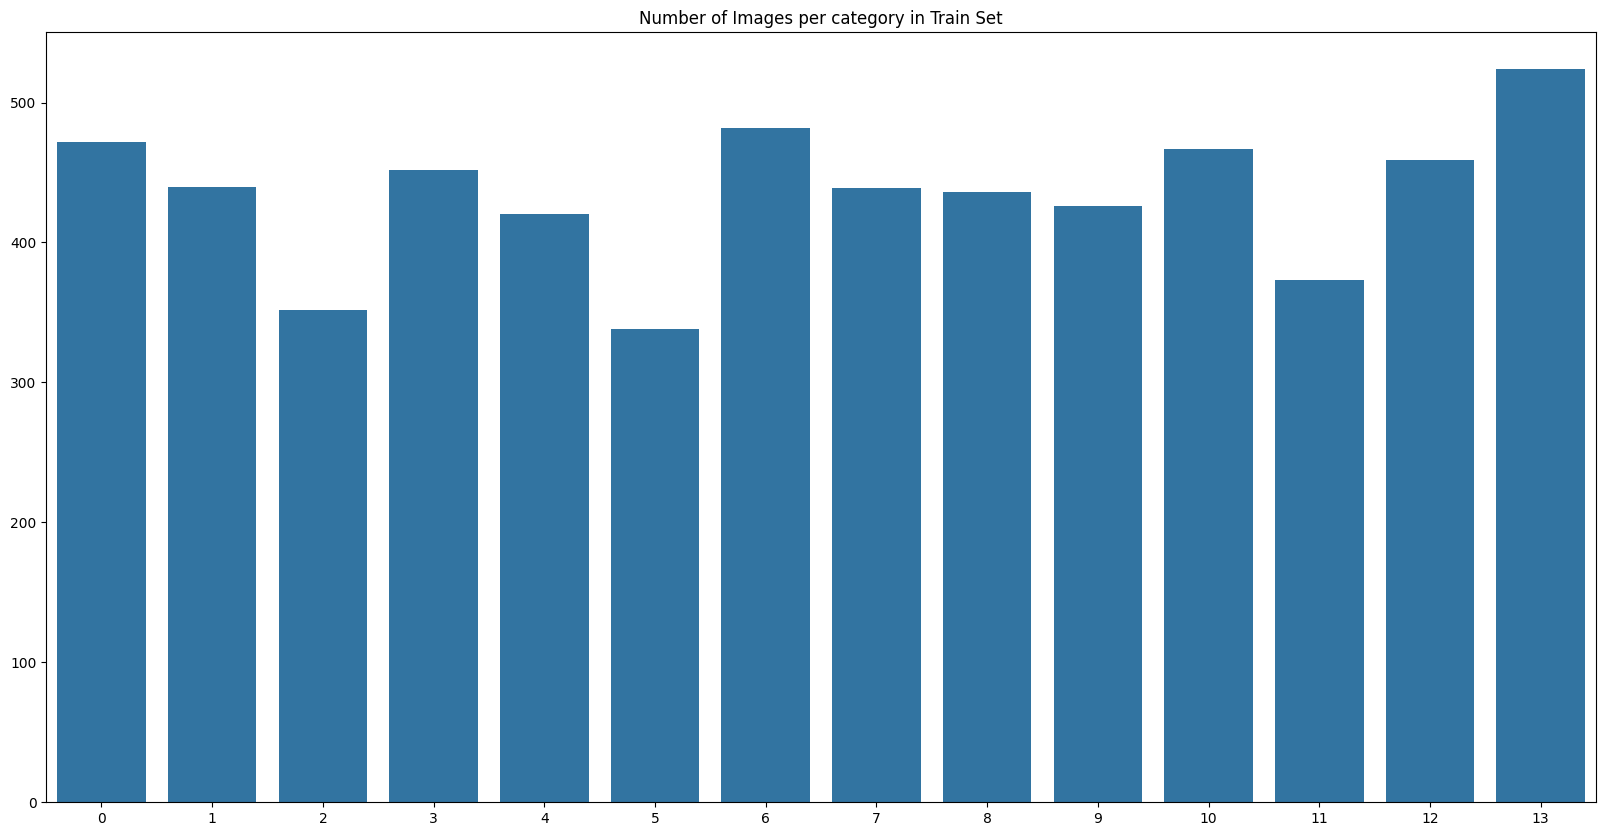

In [13]:
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(x=unique_train,y= count_train).set_title('Number of Images per category in Train Set')
plt.show()

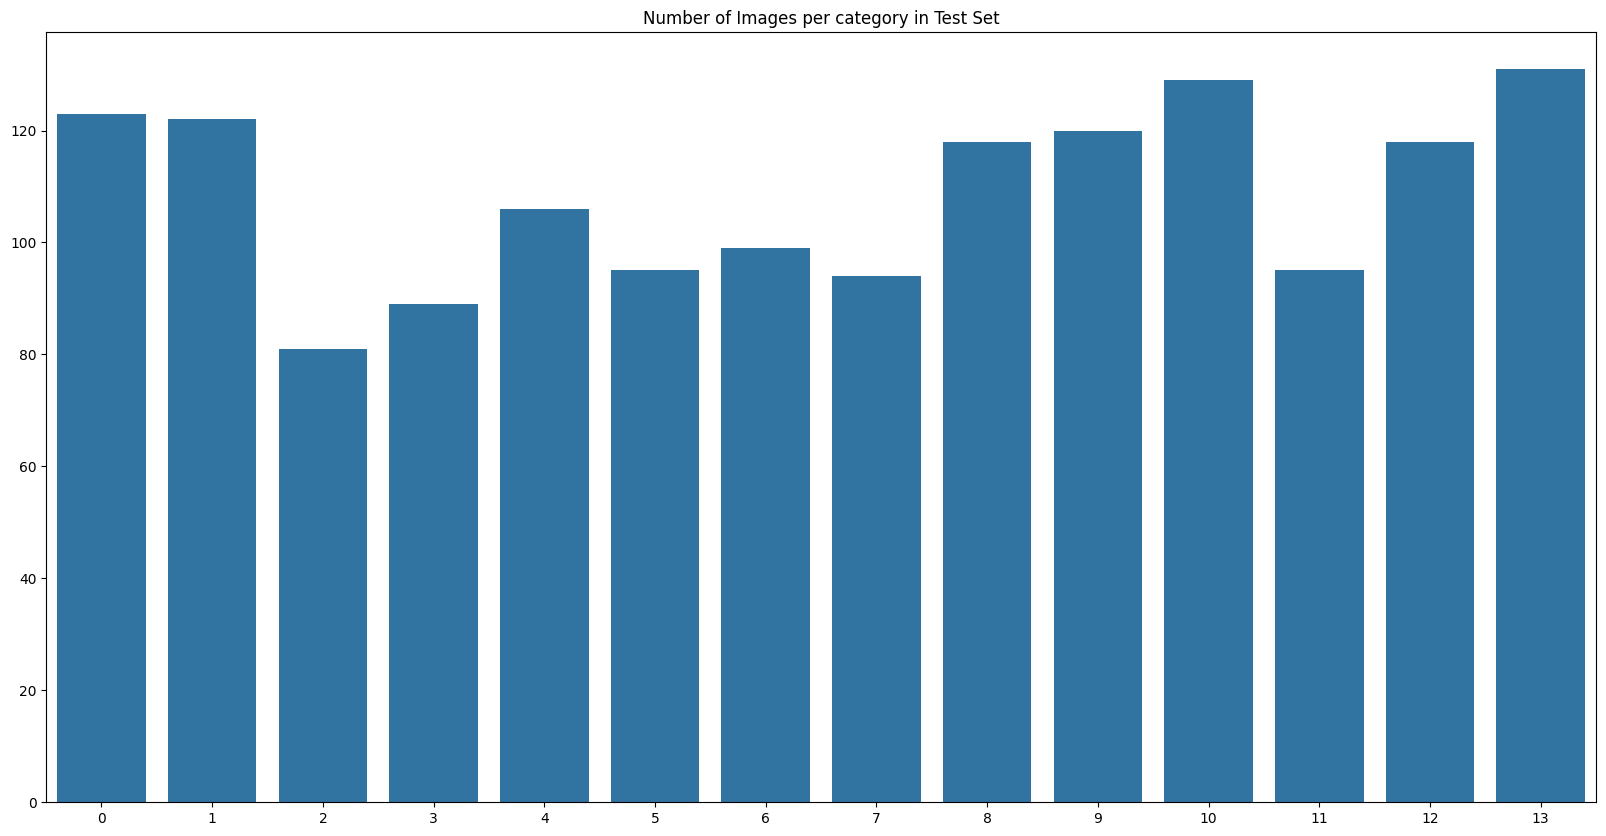

In [14]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(x=unique_test, y=count_test).set_title('Number of Images per category in Test Set')
plt.show()

In [15]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6080, 32, 32, 1)
(1520, 32, 32, 1)
(6080, 14)
(1520, 14)


In [17]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0),
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [18]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                   

In [19]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('maths_symbol_and_digits_recognition.h5',
                             monitor='val_loss', save_best_only=True,
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]

In [20]:
aug = ImageDataGenerator(zoom_range=0.1,
#                          rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))
# hist2 = model2.fit(X_train, Y_train, batch_size=128, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

Epoch 1/100
48/48 [==============================] - 15s 268ms/step - loss: 2.7976 - accuracy: 0.2196 - val_loss: 2.2313 - val_accuracy: 0.4724
Epoch 2/100
48/48 [==============================] - 12s 249ms/step - loss: 1.7681 - accuracy: 0.5459 - val_loss: 1.5452 - val_accuracy: 0.6816
Epoch 3/100
48/48 [==============================] - 12s 252ms/step - loss: 1.2850 - accuracy: 0.6740 - val_loss: 1.1550 - val_accuracy: 0.7428
Epoch 4/100
48/48 [==============================] - 11s 227ms/step - loss: 1.0059 - accuracy: 0.7564 - val_loss: 1.1195 - val_accuracy: 0.7349
Epoch 5/100
48/48 [==============================] - 10s 210ms/step - loss: 0.8837 - accuracy: 0.7859 - val_loss: 0.9698 - val_accuracy: 0.7829
Epoch 6/100
48/48 [==============================] - 12s 242ms/step - loss: 0.7723 - accuracy: 0.8224 - val_loss: 0.9308 - val_accuracy: 0.7737
Epoch 7/100
48/48 [==============================] - 15s 311ms/step - loss: 0.6861 - accuracy: 0.8416 - val_loss: 0.7089 - val_accuracy:

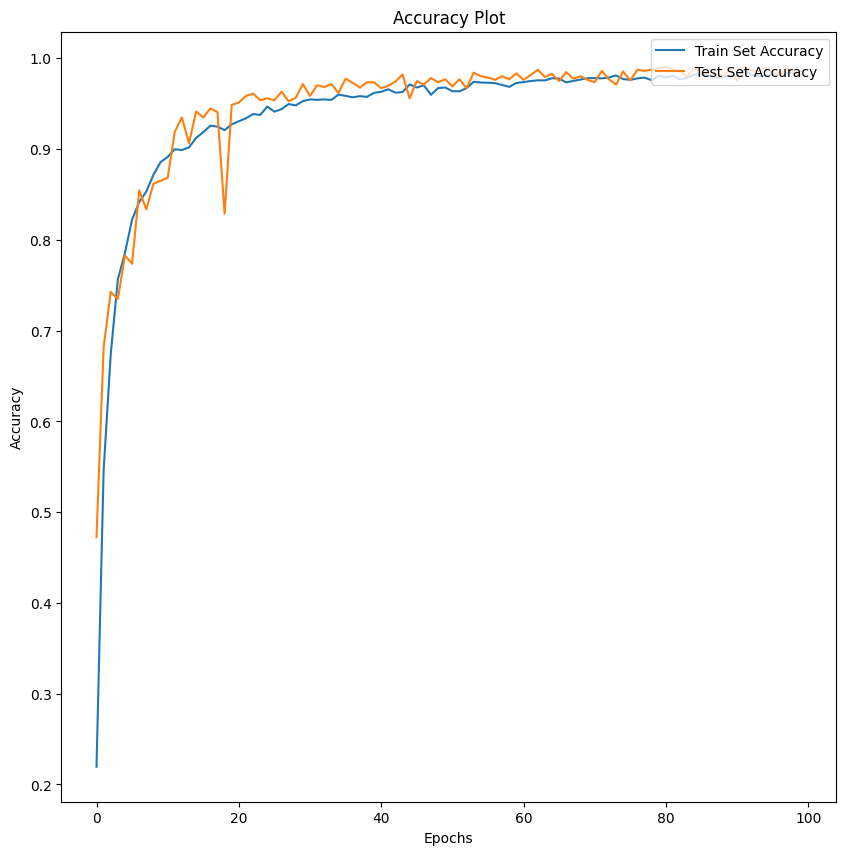

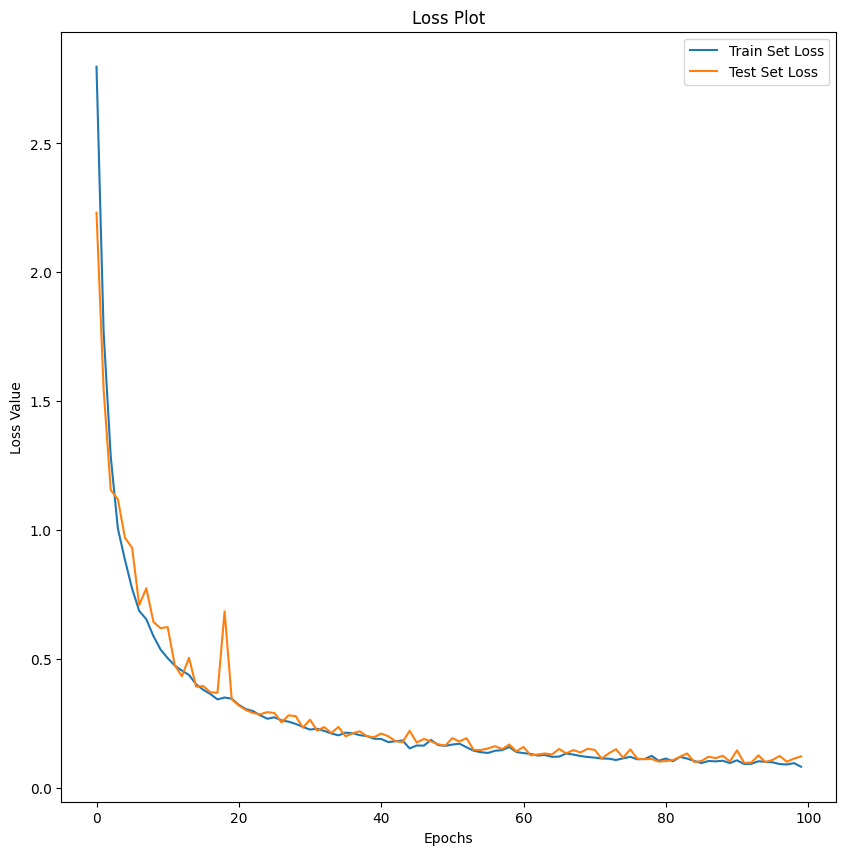

In [21]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

In [22]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_hat, ypred))

48/48 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       123
           1       0.98      1.00      0.99       122
           2       0.98      1.00      0.99        81
           3       1.00      0.97      0.98        89
           4       0.96      0.99      0.98       106
           5       1.00      0.99      0.99        95
           6       0.94      0.99      0.97        99
           7       1.00      0.96      0.98        94
           8       1.00      0.93      0.96       118
           9       0.97      0.96      0.96       120
          10       0.99      0.98      0.99       129
          11       1.00      1.00      1.00        95
          12       1.00      0.99      1.00       118
          13       0.98      1.00      0.99       131

    accuracy                           0.98      1520
   macro avg       0.98      0.98      0.98      1520
weighted avg       0.98   

In [23]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
batch_size = 64
epochCount = 20
learningRate = 0.0005
batchrow = int(batch_size / 8)

In [33]:
# taken from https://stackoverflow.com/a/56512552
def imshow(image, ax=None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
      fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))

  if normalize:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      image = std * image + mean
      image = np.clip(image, 0, 1)

  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')

  return ax

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time

In [51]:
# Define the variable image
image = torch.randn(3, 224, 224)

# Print the type of the image variable
print(type(image))

# Access the variable in a different code block or function
def my_function():
    global image
    print(type(image))

my_function()

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [36]:
print(type(image))

<class 'torch.Tensor'>


In [48]:
dataset = torchvision.datasets.ImageFolder(root='data/dataset', transform=transforms.ToTensor())

# dataloaders "represent a Python iterable over a dataset"
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True)

In [52]:
image = torch.tensor(image)

<ipython-input-52-131777ac042c>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)


In [53]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True, collate_fn=lambda x: x)

In [55]:
mean = 0.
std = 0.

# what does this do?
for batch_idx, data in enumerate(dataloader, 0):
    label = data
    batchSize = image.size(0)
    image = image.view(batchSize, image.size(1), -1)
    mean += image.mean(2).sum(0)
    std += image.std(2).sum(0)

mean /= len(dataset)
std /= len(dataset)
print(mean, std)

tensor([ 1.3800e-03, -2.2761e-05,  3.2101e-03,  1.0713e-03,  7.5237e-04,
        -6.6066e-04, -1.9617e-04,  4.3541e-03,  1.9852e-03,  2.3293e-04,
         6.6244e-04, -6.6499e-04, -1.1730e-03, -1.2965e-03,  2.0585e-03,
         2.6051e-03, -2.3596e-03, -1.2255e-03,  6.3309e-03,  2.0102e-05,
         1.0060e-04,  9.4049e-04, -3.3481e-04, -2.4364e-03, -6.0393e-04,
         1.7327e-04,  3.7227e-03,  2.0904e-03, -3.2988e-04, -2.4358e-04,
         4.6394e-04, -1.1276e-03,  3.1291e-05, -3.3825e-04, -2.5598e-03,
        -1.5653e-03,  5.8626e-04,  7.1204e-04,  3.3414e-03,  2.2121e-04,
        -4.4814e-03, -1.3732e-03,  1.8660e-03, -2.4801e-03,  7.4890e-04,
        -1.2802e-03, -8.8261e-04, -1.8848e-03,  7.0738e-04,  4.2608e-04,
        -1.9805e-03, -2.9331e-03, -6.0977e-04, -7.7891e-04,  1.7294e-03,
        -3.8149e-04, -2.4717e-03, -3.6594e-03,  3.5381e-04, -1.0386e-03,
         7.5599e-04, -1.4689e-03, -7.6479e-04,  2.5779e-03, -5.3748e-04,
         5.9614e-04, -1.5422e-03, -9.0426e-05,  1.9

In [56]:
len(dataset)

7600

In [57]:
trfms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((std),(mean))])

dataset = torchvision.datasets.ImageFolder(root='data/dataset', transform=transforms.ToTensor())
len(dataset)

7600

In [60]:
trainset, valset = torch.utils.data.random_split(dataset, [7000, 600])

#testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=int(batch_size / 5), shuffle=True, num_workers=2)

#testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '(', ')', '!', '+', ',', '-', '=', '[', ']', '{', '}', 'alpha', 'ascii_124', 'beta', 'cos', 'Delta', 'div', 'exists',
'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'in', 'infty', 'int', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'M', 'mu', 'neq', 'phi', 'pi', 'pm', 'prime', 'rightarrow',
'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
'y', 'z')

In [61]:
#@title Under construction
#under construction
"""
exp_labels_list = []
for i in range(100):
  _,label = trainset[i]
  exp_labels_list.append(label)
print(exp_labels_list)
trainset.targets
"""

'\nexp_labels_list = []\nfor i in range(100):\n  _,label = trainset[i]\n  exp_labels_list.append(label)\nprint(exp_labels_list)\ntrainset.targets\n'

In [62]:
#@title Under construction
#under construction, code for dataset splitter with equal distribtuion of classes
"""
eqsplitloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False,num_workers=2)

clinp_list = [] # list of lists, containing images sorted by classes
cltgt_list = [] # list of lists, containing labels for images
cl_count = len(classes)
flag = 0 #constatnt to flag if the image of this class was already sorted
inp_list = []
tgt_list = []
for i in range(cl_count):
  empty_list = []
  clinp_list.append(empty_list)
  cltgt_list.append(empty_list)

for i, data in enumerate(eqsplitloader, 0):
  inp, tgt = data
  inp_list.append(inp)
  tgt_list.append(tgt)

print(inp_list[0])
print(tgt_list[0])

 emptycl_idx = 0 #index of first empty list in list of lists
  clinp_list[emptycl_idx].append(inp[0]) #sorting the first image and its label
  cltgt_list[emptycl_idx].append(tgt[0])
  for k in range(i): #running check

    if tgt[i] == tgt[k]:
      flag = 1
      break
  if flag == 1: #if there is list for class of next item in dataloader
    for j in range(cl_count):
          if tgt[i] != cltgt_list[j][0]: #find it
            continue
          else:
             clinp_list[j].append(inp[i]) #store it and its label
            cltgt_list[j].append(tgt[i])
            break
  else: #if loaded image is of new class
    emptycl_idx += 1 #move index of first empty list
    clinp_list[emptycl_idx].append(inp[i]) #store the imge and its label
    cltgt_list[emptycl_idx].append(tgt[i])
"""


'\neqsplitloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False,num_workers=2)\n\nclinp_list = [] # list of lists, containing images sorted by classes\ncltgt_list = [] # list of lists, containing labels for images\ncl_count = len(classes)\nflag = 0 #constatnt to flag if the image of this class was already sorted\ninp_list = []\ntgt_list = []\nfor i in range(cl_count):\n  empty_list = []\n  clinp_list.append(empty_list)\n  cltgt_list.append(empty_list)\n\nfor i, data in enumerate(eqsplitloader, 0):\n  inp, tgt = data\n  inp_list.append(inp)\n  tgt_list.append(tgt)\n\nprint(inp_list[0])\nprint(tgt_list[0])\n\n emptycl_idx = 0 #index of first empty list in list of lists\n  clinp_list[emptycl_idx].append(inp[0]) #sorting the first image and its label\n  cltgt_list[emptycl_idx].append(tgt[0])\n  for k in range(i): #running check\n\n    if tgt[i] == tgt[k]:\n      flag = 1\n      break\n  if flag == 1: #if there is list for class of next item in dataloader\n    for j in 

In [63]:
print(len(trainset))
print(len(valset))
epoch_count_train = int(len(trainset) / batch_size)
epoch_count_val = int(5 * len(valset) / batch_size)
print(epoch_count_train)
print(epoch_count_val)

7000
600
109
46


In [67]:
class skynet1(nn.Module):
  def __init__(self):
    super(skynet1, self).__init__()
    self.conv00 = nn.Conv2d(3, 8, 10)
    self.conv01 = nn.Conv2d(8, 8, 9)
    torch.nn.init.xavier_uniform_(self.conv00.weight)
    torch.nn.init.xavier_uniform_(self.conv01.weight)
    self.conv1 = nn.Conv2d(3, 8, 3) #3 input channels, 8 output channels(number of filters), 3x3 kernel, stride 1, no padding
    torch.nn.init.xavier_uniform_(self.conv1.weight)
    self.pool1 = nn.MaxPool2d(2, 2, 1) #2x2 filter, stride 2, padding 1
    self.conv2 = nn.Conv2d(8, 16, 3)
    torch.nn.init.xavier_uniform_(self.conv2.weight)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(16, 128, 6)
    torch.nn.init.xavier_uniform_(self.conv3.weight)
    self.fc1 = nn.Linear(128, 64)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    self.fc2 = nn.Linear(64, 10)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    #self.dropout1 = nn.Dropout(0.1)
    #self.dropout2 = nn.Dropout(0.5)

  def forward(self, x):
    x = F.relu(self.conv00(x))
    x = F.relu(self.conv01(x))
    #x = self.dropout1(x)
    x = F.relu(self.conv1(x))
    #x = self.dropout1(x)
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    #x = self.dropout1(x)
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    #x = self.dropout1(x)
    x = x.view(-1, 128)
    x = self.fc1(x)
    #x = self.dropout2(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x
net = skynet1()


In [68]:
params = list(net.parameters())
print(len(params))
for i in range(10):
  print(params[i].size())

14
torch.Size([8, 3, 10, 10])
torch.Size([8])
torch.Size([8, 8, 9, 9])
torch.Size([8])
torch.Size([8, 3, 3, 3])
torch.Size([8])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([128, 16, 6, 6])
torch.Size([128])
